In [111]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import math
from copy import deepcopy


# Custome Dataset

In [112]:
# Custom Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # load the images and labels
        self.images, self.labels = self.load_images_and_labels()
        # encode the labels
        self.le = LabelEncoder()
        self.labels = self.le.fit_transform(self.labels)
    
    def load_images_and_labels(self):
        images, labels = [], []
        for label in os.listdir(self.data_dir):
            folder_path = os.path.join(self.data_dir, label)
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)
                images.append(img)
                labels.append(label)
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def labels_inverse_transform(self, labels):
        return self.le.inverse_transform(labels)

## Create the dataset and plot a few images

In [116]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # pretrained resnet normalization
])

# Create dataset and dataloaders
dataset = BrainTumorDataset("/kaggle/input/brain-tumor-mri-scans", transform=transform)

In [126]:
def plot_images(images, labels, predictions=None, denormalize=None, img_size=4, hspace=0.9):
    N = len(images)
    ncols = 2 if N > 1 else 1
    nrows = math.ceil(N/2) if N else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*img_size, nrows*img_size))
    for idx, image in enumerate(images):
        title = f"label={labels[idx]}"
        if predictions is not None:
            title += f"\nprediction={predictions[idx]}"
        
        if denormalize is not None:
            image = denormalize(image)
        
        image = image.cpu().numpy().transpose((1, 2, 0))
        if N == 1:
            axes.imshow(image)
            axes.set_title(title)
        else:
            i, j = idx // 2, idx % 2
            axes[i, j].imshow(image)
            axes[i, j].set_title(title)
    plt.subplots_adjust(hspace=hspace)
    plt.show()

In [ ]:
images, labels = zip(*[dataset[i] for i in range(4)])
plot_images(images, dataset.labels_inverse_transform(labels), predictions=None, denormalize=transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1/0.229, 1/0.224, 1/0.225]))

## Split data to train, validation and test

In [ ]:
dataset_n = len(dataset)
print(f"total_samples={dataset_n}")
print(f"65%={dataset_n*0.65}")
print(f"15%={dataset_n*0.15}")
print(f"20%={dataset_n*0.2}")

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[4565, 1053, 1405])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# don't shuffle validation and test sets.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
np.arange(16).reshape((4,4)).mean(axis=0)

In [ ]:
def print_logs(logs, main_msg=""):
    if main_msg:
        print(main_msg)
    for k, v in logs.items():
        print(f"\t* {k} {v}")

        
def run_epoch(dataloader, model, optimizer, criterion, device, training=True):
    if training:
        model.train()
        
    running_loss = 0.0
    confusion_matrix = np.zeros((4, 4))
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backward pass and optimization step
        loss.backward()
        optimizer.step()

        # update running loss and confusion matrix
        running_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)     
        for y_true in range(4):
            for y_pred in range(4):
                confusion_matrix[y_true, y_pred] += (preds[labels == y_true] == y_pred).sum().item()

    epoch_loss = running_loss/len(dataloader)
    recall = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    precision = np.diag(confusion_matrix) / confusion_matrix.sum(axis=0)
    f1 = 2 * recall * precision / (recall + precision)
    return {"loss": epoch_loss, "recall": recall, "precision": precision, "f1_score": f1}


def update_logs(logs, epoch_logs, epoch_type="train"):
    for k, v in epoch_logs.items():
        if k not in logs[epoch_type]:
            logs[epoch_type][k] = []
        logs[epoch_type][k].append(v)
    
    
def train_model(train_loader, val_loader, test_loader, model, optimizer, criterion, n_epochs, device, early_stopping=10):
    best_model, best_val_loss, no_progress = None, np.inf, 0
    logs = {"train": dict(), "val": dict(), "test": dict()}
    model = model.to(device)
    for epoch in range(n_epochs):
        model.train()
        # train epoch
        train_logs = run_epoch(train_loader, model, optimizer, criterion, device, training=True)
        print_logs(train_logs, main_msg=f"Train Logs/ Epoch {epoch + 1}")
        update_logs(logs, train_logs, epoch_type="train")

        model.eval()
        # val epoch
        val_logs = run_epoch(val_loader, model, optimizer, criterion, device, training=False)
        print_logs(val_logs, main_msg=f"Val Logs/ Epoch {epoch + 1}")
        update_logs(logs, val_logs, epoch_type="val")
        # test epoch
        test_logs = run_epoch(test_loader, model, optimizer, criterion, device, training=False)
        print_logs(test_logs, main_msg=f"Test Logs/ Epoch {epoch + 1}")
        update_logs(logs, test_logs, epoch_type="test")
        
        # update best model and check for early stopping
        if val_logs["loss"] < best_val_loss:
            best_val_loss = val_logs["loss"]
            no_progress = 0
            best_model = deepcopy(model)
        else:
            no_progress += 1
            if no_progress == early_stopping:
                break
        print("=" * 100)
    return best_model, logs


def eval_model(dataloader, model, optimizer, criterion, device):
    model.eval()
    eval_logs = run_epoch(dataloader, model, optimizer, criterion, device, training=False)
    print_logs(eval_logs, "Best Model Evaluation:")
        

def run_training(train_loader, val_loader, test_loader, model, optimizer, criterion, n_epochs, device, early_stopping=10):
    best_model, logs = train_model(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,model=model, optimizer=optimizer, criterion=criterion, n_epochs=n_epochs, device=device, early_stopping=early_stopping)
    return best_model, logs

## Let's start training some models.

In [ ]:
# load pretrained ResNet18 model and view its architecture 
model = models.resnet18(pretrained=True)
print(model)

Let's test transfer learning by freezing all models weights and trainig a new "head" with 4 classes instead of 1000!

Get device (cpu or cuda)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device={device}")

train and test performance.

In [ ]:
# load model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freezing model weights
for param in model.parameters():
    param.requires_grad = False
    
# replace model head with new head - make sure the head requires grad
model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

# define optimizer, give the optimizer only the parameters that requires_grad.
optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# define criterion
criterion = torch.nn.CrossEntropyLoss()

transfer_learning_best_model, transfer_learning_logs = run_training(train_loader=train_loader,
                                        val_loader=val_loader,
                                        test_loader=test_loader,
                                        model=model,
                                        optimizer=optimizer,
                                        criterion=criterion,
                                        n_epochs=20,
                                        device=device,
                                        early_stopping=3)

In [ ]:
probabilities = []
for y in np.unique(dataset.labels):
    count = np.sum(dataset.labels == y)
    probabilities.append(count)
    print(f"{dataset.labels_inverse_transform([y])[0]} has {count} samples")
probabilities = probabilities / np.sum(probabilities)

In [ ]:
def plot_logs(logs, weights):
    for key, sub_logs in logs.items():
        fig, axes= plt.subplots(nrows=1, ncols=len(sub_logs.keys()), figsize=(5 * len(sub_logs.keys()), 4))
        fig.suptitle(f"{key} per-class metrics")
        for idx, metric in enumerate(sub_logs.keys()):
            values = sub_logs[metric]
            if isinstance(values[0], np.ndarray):
                values = np.vstack(values)
                for y in range(values.shape[1]):
                    axes[idx].plot(values[:, y], marker="x", label=dataset.labels_inverse_transform([y])[0])
                    axes[idx].legend()                
            else:
                axes[idx].plot(values, marker="x")
            axes[idx].set_title(metric)
            axes[idx].grid()
            axes[idx].set_xlabel("epoch")
            axes[idx].set_ylabel(metric)
        plt.show()
        plt.close()
        
        fig, axes= plt.subplots(nrows=1, ncols=len(sub_logs.keys()), figsize=(5 * len(sub_logs.keys()), 4))
        fig.suptitle(f"{key} class average metrics")
        for idx, metric in enumerate(sub_logs.keys()):
            values = sub_logs[metric]
            if isinstance(values[0], np.ndarray):
                values = np.vstack(values) * np.array(weights).reshape((1, -1))
                values = values.sum(axis=1)
            axes[idx].plot(values, marker="x")
            axes[idx].set_title(metric)
            axes[idx].grid()
            axes[idx].set_xlabel("epoch")
            axes[idx].set_ylabel(metric)
        plt.show()
        plt.close()

In the graphs below we can see that we probably could train the model a bit more. 
Also we can cleary see that the model succeeds the most on the "healthy" samples while struggling on the "pituitary" sample.

In [ ]:
plot_logs(transfer_learning_logs, weights=probabilities)

Let's check the model performance when fine-tuning the head and the last layer (layer4).

In [114]:
import torch.nn as nn
import torchvision.models as models

# Load the ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 weights for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# replace model head with new head - make sure the head requires grad
model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

# define optimizer, give the optimizer only the parameters that requires_grad.
# notice that since layer4 weights are already trained, we don't want to change them to much.. that is why we use lr=1e-5 instead of 1e-3.
optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# define criterion
criterion = torch.nn.CrossEntropyLoss()

fine_tuning_best_model, fine_tuning_logs = run_training(train_loader=train_loader,
                                        val_loader=val_loader,
                                        test_loader=test_loader,
                                        model=model,
                                        optimizer=optimizer,
                                        criterion=criterion,
                                        n_epochs=20,
                                        device=device,
                                        early_stopping=3)

Train Logs/ Epoch 1
	* loss 0.6917919987565154
	* recall [0.73455598 0.88683603 0.53574745 0.91153513]
	* precision [0.80189673 0.8820827  0.68527316 0.71594005]
	* f1_score [0.76675063 0.88445298 0.60135487 0.80198398]
Val Logs/ Epoch 1
	* loss 0.35860533289837115
	* recall [0.82378855 0.97115385 0.73790323 0.95864662]
	* precision [0.89903846 0.93518519 0.78540773 0.88541667]
	* f1_score [0.85977011 0.95283019 0.76091476 0.92057762]
Test Logs/ Epoch 1
	* loss 0.2964694775979627
	* recall [0.85195531 0.94601542 0.76875    0.96153846]
	* precision [0.89181287 0.94117647 0.77115987 0.92067989]
	* f1_score [0.87142857 0.94358974 0.76995305 0.9406657 ]
Train Logs/ Epoch 2
	* loss 0.2946131105397965
	* recall [0.9015444  0.9799846  0.7818013  0.97484822]
	* precision [0.91478942 0.9450631  0.87073423 0.91382114]
	* f1_score [0.90811862 0.96220711 0.82387476 0.94334872]
Val Logs/ Epoch 2
	* loss 0.21575046669353137
	* recall [0.89427313 0.99038462 0.84274194 0.98496241]
	* precision [0.9441

As you can see in the logs below, we could reach 100% accuracy when also fine-tunings the last layer of the model.

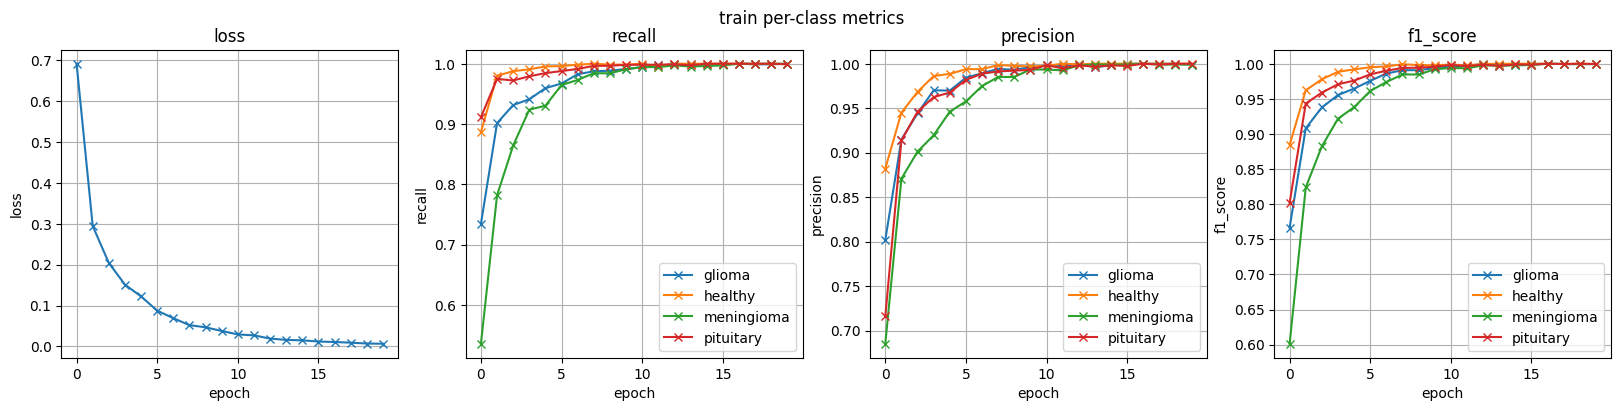

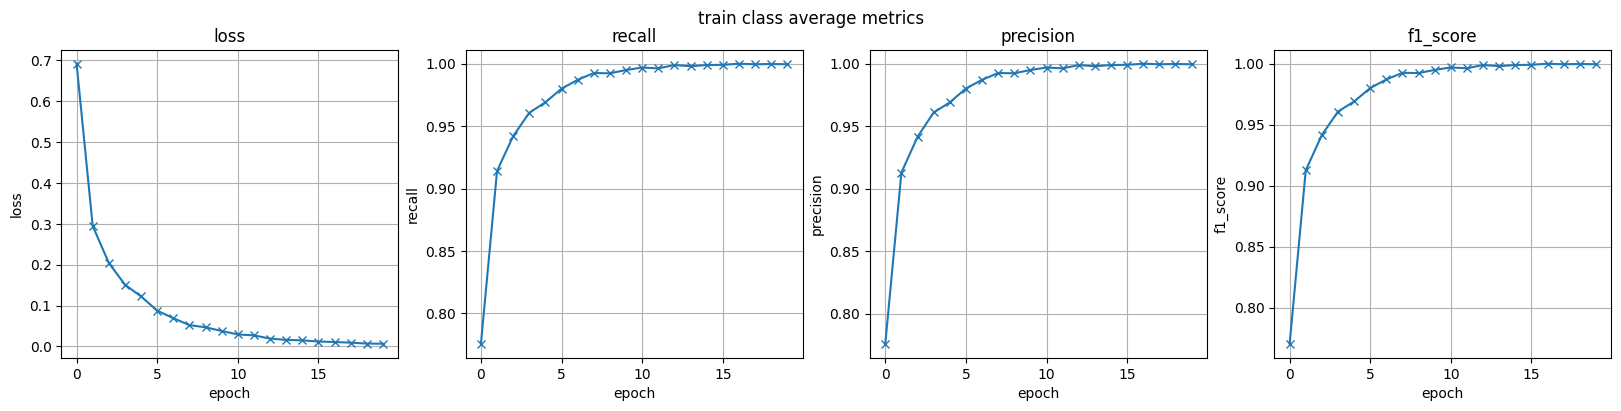

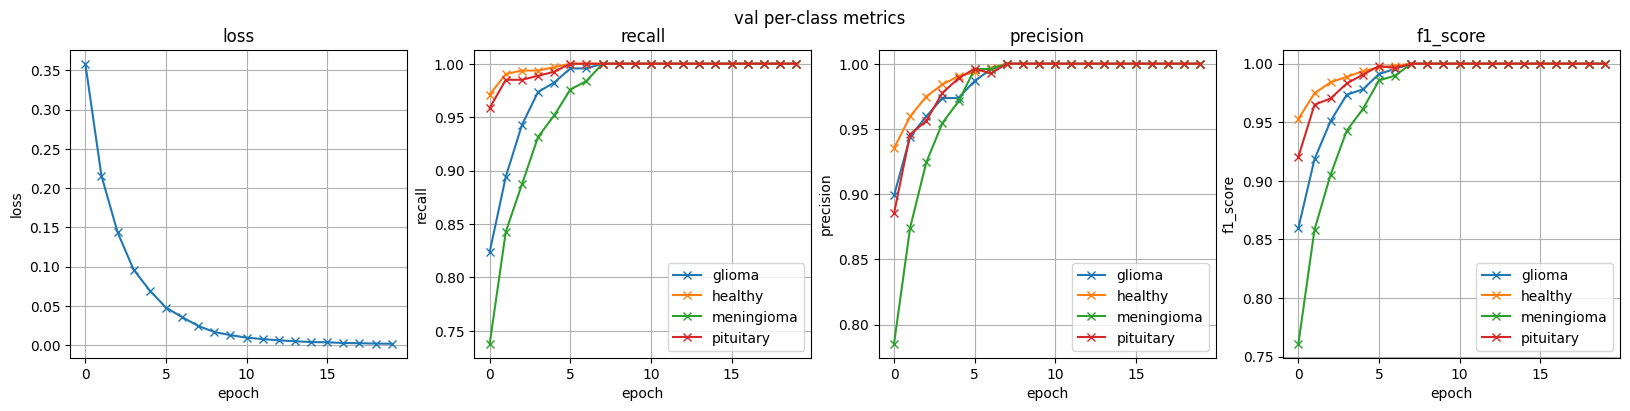

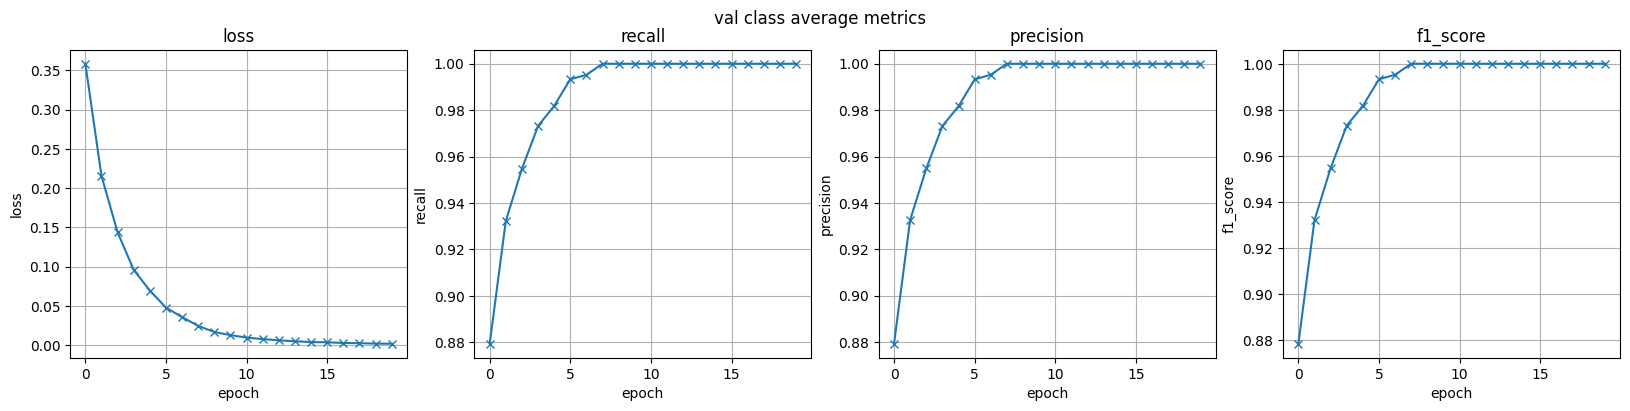

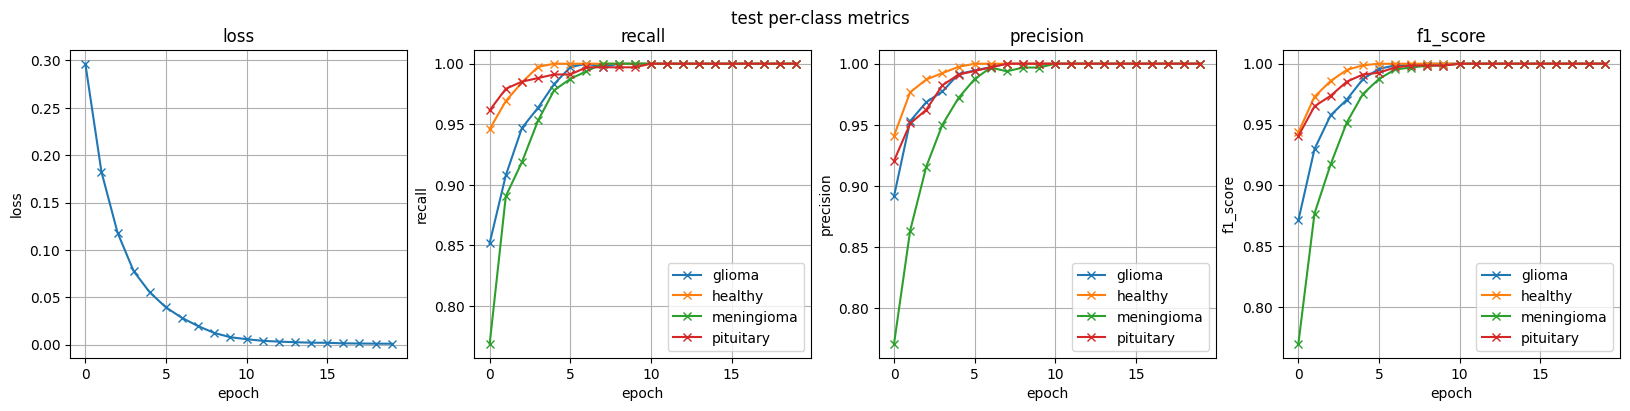

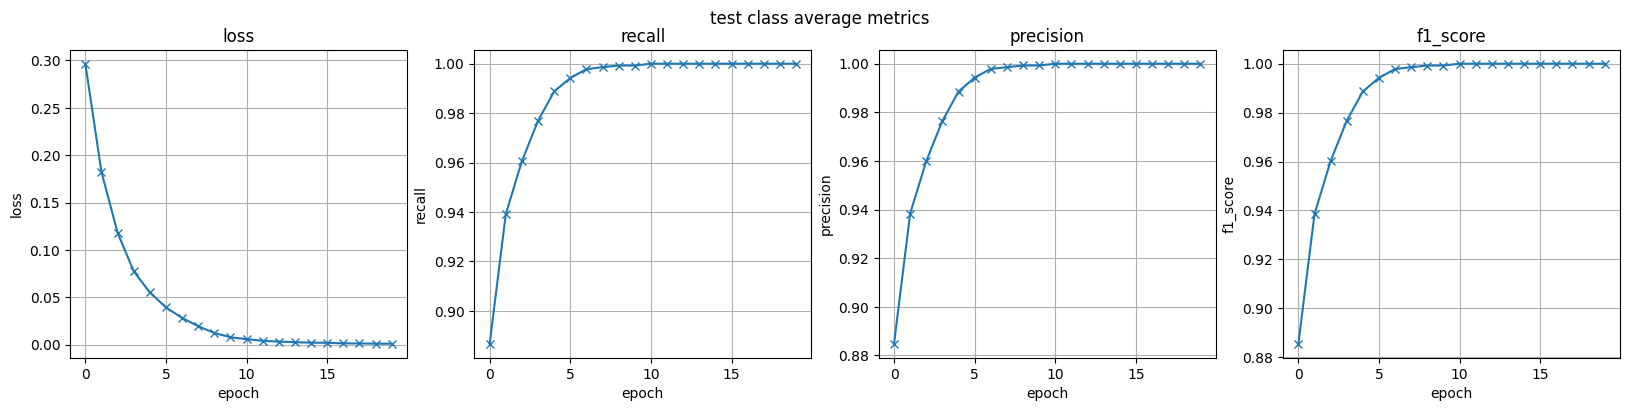

In [115]:
plot_logs(fine_tuning_logs, weights=probabilities)

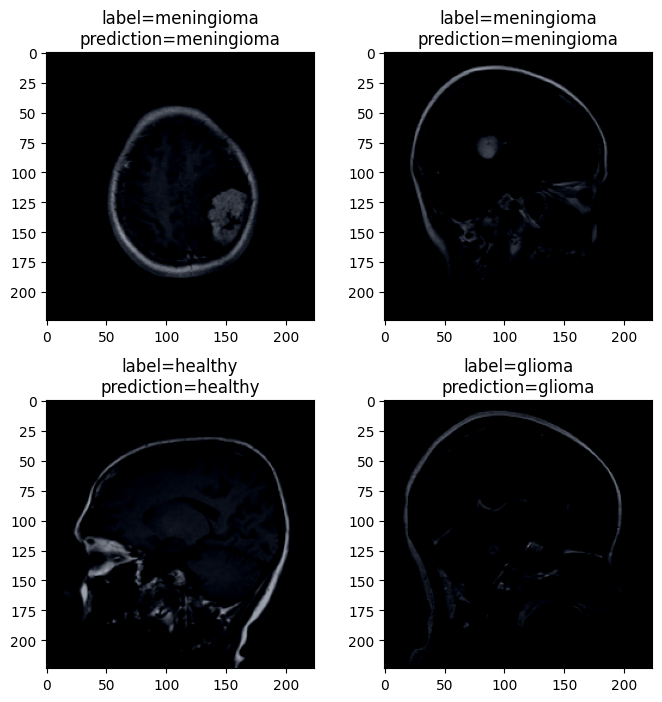

In [131]:
fine_tuning_best_model.eval()

# Get a batch of images from the test set
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Select 4 random images
indices = np.random.choice(a=np.arange(len(images)), size=4, replace=False).astype(np.int64)
images = images[indices]
labels = labels[indices]

# Get model predictions
outputs = fine_tuning_best_model(images)
_, preds = torch.max(outputs, 1)  # get the predicted class indices

plot_images(images.cpu(), dataset.labels_inverse_transform(labels.cpu().numpy()), predictions=dataset.labels_inverse_transform(preds.cpu().numpy()),
            denormalize=transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1/0.229, 1/0.224, 1/0.225]), hspace=0.3)